# Residue Constants

In [3]:
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import os

from collections import defaultdict
from poc.analysis.af_residue_constants import rigid_group_atom_positions

## Sample Files

In [8]:
data_dir = 'data'
transformed_data = data_dir + '/transformed.json'
if os.path.exists(transformed_data):
    os.remove(transformed_data)
samples = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir)]
samples = [sample for sample in samples if '.DS_Store' not in sample]
samples

['data/3cln.cif',
 'data/2bl2.cif',
 'data/8zts.cif',
 'data/4hhb.cif',
 'data/8xnj.cif',
 'data/1stp.cif',
 'data/4ake.cif',
 'data/2hhb.cif',
 'data/9f2a.cif',
 'data/5t4p.cif',
 'data/6m17.cif',
 'data/9jwd.cif',
 'data/1a4y.cif',
 'data/9h44.cif',
 'data/8ykn.cif']

## Process files to new format

In [9]:
amino_acids = []
for sample in samples:
    with open(sample, 'r') as f:
        chain_before = None
        seq_id_before = None
        current_aa = []
        current_chain = defaultdict(list)
        for line in f:
            data = line.strip().split()
            if data[0] != 'ATOM': continue
            seq_id = data[8]
            chain = data[18]
            if chain != chain_before and chain_before is not None:
                amino_acids.append(*current_chain.values())
                current_chain = defaultdict(list)
            if seq_id != seq_id_before and seq_id_before is not None:
                current_chain[chain].append(current_aa)
                current_aa = []
            aa = data[5]
            atom_id = data[3]
            x = float(data[10])
            y = float(data[11])
            z = float(data[12])
            if len(current_aa) == 0:
                current_aa.append(data[5])
            current_aa.append((atom_id, x, y, z))
            chain_before = chain
            seq_id_before = seq_id
        amino_acids.append(*current_chain.values())

with open(transformed_data, 'w') as f:
    json.dump(amino_acids, f, indent=4)

## Data stats

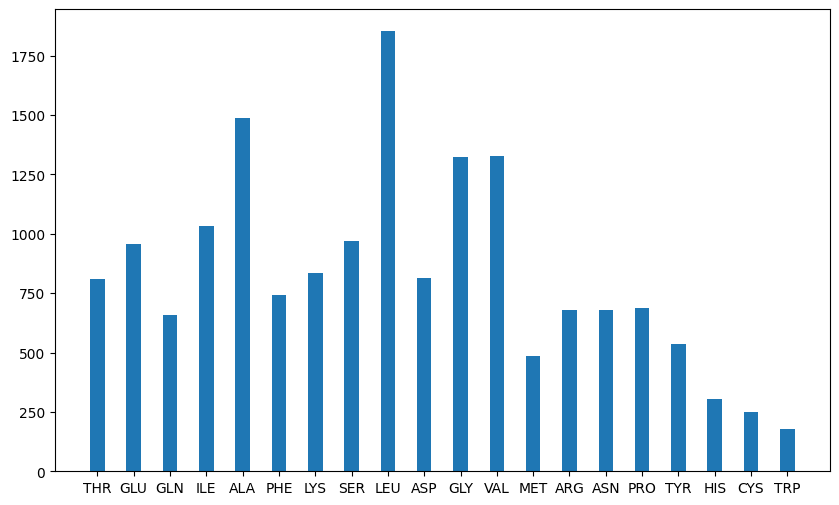

Total analyzed amino acids: 16611


In [30]:
disassembled_acids = defaultdict(int)
for chain in amino_acids:
    for aa in chain:
        disassembled_acids[aa[0]] += 1

total = sum(disassembled_acids.values())
plt.figure(figsize=(10, 6))
plt.bar(disassembled_acids.keys(), list(disassembled_acids.values()), width=0.4)
plt.show()

print('Total analyzed amino acids:', total)


### Alpha Folds Measurements

In [7]:
af_rigid_atom_positions = defaultdict(lambda: defaultdict(float))
for aa, atoms in rigid_group_atom_positions.items():
    for atom in atoms:
        af_rigid_atom_positions[aa][atom[0]] = math.sqrt(atom[2][0]**2 + atom[2][1]**2 + atom[2][2]**2)

### Ca - Ca distance

In [76]:
ca_ca_distances = []
af_ca_ca = 3.80209737096
for chain in amino_acids:
    ca_before = None
    for aa in chain:
        for atom in aa[1:]:
            if atom[0] != 'CA': continue
            if ca_before is None:
                ca_before = atom
                continue
            ca_ca_distances.append(
                math.sqrt(
                    (ca_before[1]-atom[1])**2 + (ca_before[2]-atom[2])**2 + (ca_before[3]-atom[3])**2
                )
            )
            ca_before = atom

ca_ca_distances = np.array(list(filter(lambda v: 2.5 < v < 4.5, ca_ca_distances)))
# ca_ca_distances = np.array(ca_ca_distances)

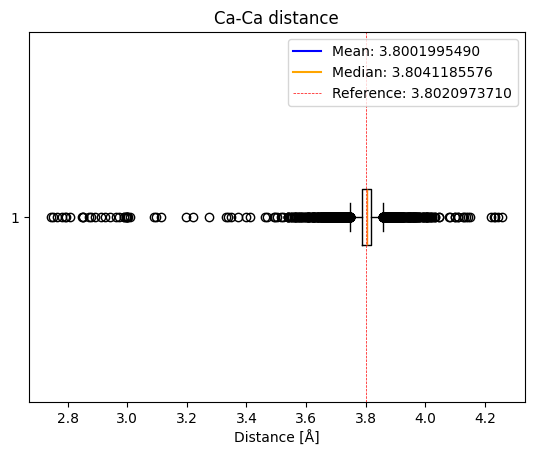

In [77]:
plt.boxplot(ca_ca_distances, vert=False)
plt.axvline(x=af_ca_ca, color='red', linestyle='--', linewidth=0.5)

handles = [
    plt.Line2D([0], [0], color='blue', label=f"Mean: {np.mean(ca_ca_distances):.10f}"),
    plt.Line2D([0], [0], color='orange', label=f"Median: {np.median(ca_ca_distances):.10f}"),
    plt.Line2D([0], [0], color='red', linestyle='--', linewidth=0.5, label=f"Reference: {af_ca_ca:.10f}")
]
plt.legend(handles=handles, loc='upper right')

plt.title('Ca-Ca distance')
plt.xlabel('Distance [Å]')
plt.show()

### C - N distance

In [78]:
c_n_distances = []
for chain in amino_acids:
    c_before = None
    for aa in chain:
        for atom in aa[1:]:
            if atom[0] not in ['C', 'N']: continue
            if c_before is None and atom[0] == 'C':
                c_before = atom
                continue
            if c_before is not None and atom[0] == 'N':
                c_n_distances.append(
                    math.sqrt(
                         (c_before[1]-atom[1])**2 + (c_before[2]-atom[2])**2 + (c_before[3]-atom[3])**2
                    )
                )
                c_before = None

c_n_distances = np.array(list(filter(lambda v: 1 < v < 2, c_n_distances)))
# c_n_distances = np.array(c_n_distances)

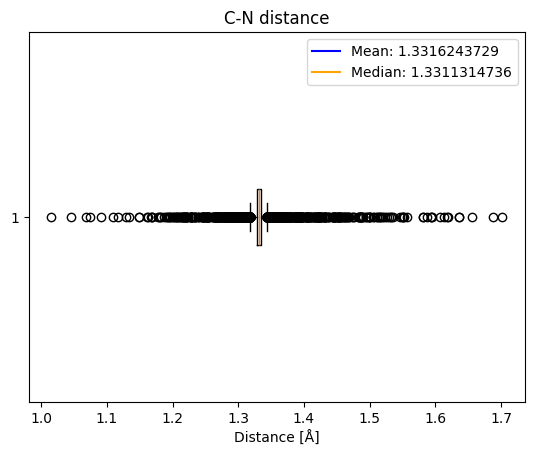

In [79]:
plt.boxplot(c_n_distances, vert=False)

handles = [
    plt.Line2D([0], [0], color='blue', label=f"Mean: {np.mean(c_n_distances):.10f}"),
    plt.Line2D([0], [0], color='orange', label=f"Median: {np.median(c_n_distances):.10f}"),
]
plt.legend(handles=handles, loc='upper right')

plt.title('C-N distance')
plt.xlabel('Distance [Å]')
plt.show()

## Angles

In [119]:
def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def calculate_angle(p1, p2, p3):
    v1_u = p1 - p2#unit_vector(p1 - p2)
    v2_u = p3 - p2#unit_vector(p3 - p2)
    print('v1', v1_u)
    print('v2', v2_u)
    return np.degrees(np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)))

The first two angles are completely within one amino acid, so the data is processed accordingly.

In [100]:
aas = defaultdict(list)
for chain in amino_acids:
    for aa in chain:
        aas[aa[0]].append(aa[1:])


### N - Ca - C


In [111]:
angles_per_aa = defaultdict(list)
for key, values in aas.items():
    for aa in values:
        n = next(atom for atom in aa if atom[0] == 'N')
        ca = next(atom for atom in aa if atom[0] == 'CA')
        c = next(atom for atom in aa if atom[0] == 'C')
        angle = calculate_angle(np.array(ca[1:]), np.array(c[1:]), np.array(n[1:]))
        angles_per_aa[key].append(angle)

all_angles = np.array([])
for key, values in angles_per_aa.items():
    all_angles = np.append(all_angles, values)

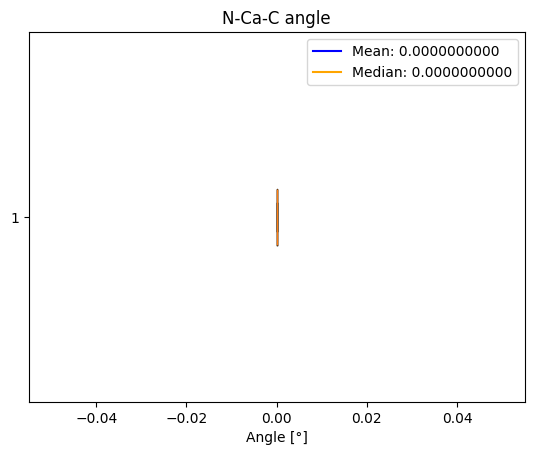

In [124]:
plt.boxplot(all_angles, vert=False)

handles = [
    plt.Line2D([0], [0], color='blue', label=f"Mean: {np.mean(all_angles):.10f}"),
    plt.Line2D([0], [0], color='orange', label=f"Median: {np.median(all_angles):.10f}"),
]
plt.legend(handles=handles, loc='upper right')

plt.title('N-Ca-C angle')
plt.xlabel('Angle [°]')
plt.show()

### Ca - C - O

In [125]:
angles_per_aa = defaultdict(list)
for key, values in aas.items():
    for aa in values:
        n = next(atom for atom in aa if atom[0] == 'CA')
        ca = next(atom for atom in aa if atom[0] == 'C')
        c = next(atom for atom in aa if atom[0] == 'O')
        angle = calculate_angle(np.array(ca[1:]), np.array(c[1:]), np.array(n[1:]))
        angles_per_aa[key].append(angle)
        break
all_angles = np.array([])
for key, values in angles_per_aa.items():
    all_angles = np.append(all_angles, values)


v1 [-0.869 -0.877  0.044]
v2 [-0.839 -1.981 -1.013]
v1 [-0.406 -1.17  -0.158]
v2 [-1.739 -1.459 -0.83 ]
v1 [-1.061 -0.639  0.133]
v2 [-1.023 -2.132  0.426]
v1 [-0.652 -1.052  0.196]
v2 [-1.292 -1.812 -0.963]
v1 [-0.623 -1.047 -0.227]
v2 [-2.14  -1.112 -0.068]
v1 [-0.826 -0.882  0.32 ]
v2 [-0.631 -2.291 -0.258]
v1 [-0.393 -1.189  0.078]
v2 [-1.611 -1.703 -0.706]
v1 [-0.121 -1.16  -0.439]
v2 [-1.561 -1.56  -0.523]
v1 [-0.744 -0.928 -0.35 ]
v2 [-1.039 -2.101  0.596]
v1 [ 0.74   0.177 -0.949]
v2 [ 0.405 -0.499 -2.27 ]
v1 [ 1.142  0.206 -0.467]
v2 [ 2.346 -0.388  0.219]
v1 [-0.758  0.807 -0.569]
v2 [-1.983  1.287  0.216]
v1 [-0.97   0.755 -0.088]
v2 [-2.231  0.331 -0.881]
v1 [-1.18   0.219 -0.386]
v2 [-1.498  0.955 -1.68 ]
v1 [-0.742 -0.636  0.736]
v2 [-0.373 -0.916  2.194]
v1 [ 0.246 -0.778 -0.946]
v2 [ 0.489 -2.248 -0.645]
v1 [-0.551  0.794 -0.777]
v2 [-0.215  2.279 -0.759]
v1 [ 0.708  0.992 -0.141]
v2 [ 2.185  0.843 -0.509]
v1 [ 0.002 -1.22   0.207]
v2 [ 1.262 -2.045 -0.025]
v1 [-0.352  

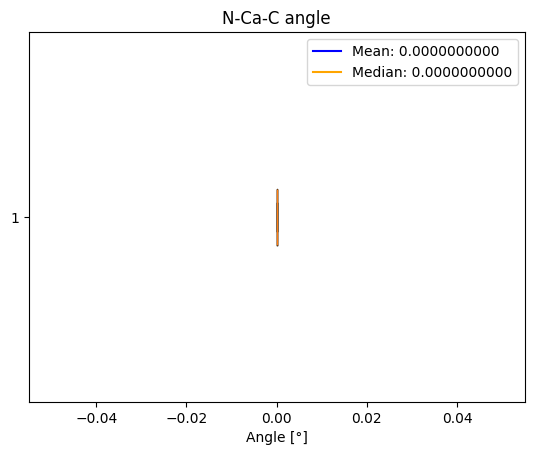

In [126]:
plt.boxplot(all_angles, vert=False)

handles = [
    plt.Line2D([0], [0], color='blue', label=f"Mean: {np.mean(all_angles):.10f}"),
    plt.Line2D([0], [0], color='orange', label=f"Median: {np.median(all_angles):.10f}"),
]
plt.legend(handles=handles, loc='upper right')

plt.title('N-Ca-C angle')
plt.xlabel('Angle [°]')
plt.show()

### Ca - C - N

### C - N - Ca

### O - C - N